In [1]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

This notebook accompanies the [week15] practice. Refer to the classwork for more details.


Your last and ultimate task is to implement and train __Convolutional Conditional VAE__. Simple VAE is available in week 15. For details about conditional VAE one can refer to [week 15 lecture](https://github.com/girafe-ai/ml-mipt/tree/advanced/week15_generative) or [this habr post (ru)](https://habr.com/ru/post/331664/)

If it seems too easy, you can use [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset instead of MNIST.

The code in general duplicates the one from the in-class practice. 

Do not forget to __use GPU acceleration during training__.

In [2]:
%matplotlib inline

In [3]:
from torchsummary import summary
import seaborn as sns
sns.set()

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

__Currently you are using device:__

In [5]:
print(device)

cuda:0


In [6]:
# It's dangerous to walk alone. Take these ;)

def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

__Data loading stuff is done for you ;)__

In [7]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
])

In [8]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [9]:
data_root = './'

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

In [11]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

__The code below is simple VAE. Your task is to make in convolutional (both encoder and decoder) and add class label information.__
<br>
Let's combine both convolutions and linear layers in encoder and decoder.

In [12]:
class ConvolutionalCVAE(nn.Module):
    def __init__(self, conv_dims, linear_dims, latent_dim, input_shape, n_labels=10):
        super().__init__()
        self.n_labels = n_labels
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu,
            scale=self._initial_sigma
        )

        result_conv_size = conv2d_size_out(input_shape[-1], 3, 2)
        result_conv_size = conv2d_size_out(result_conv_size, 3, 2)
        result_conv_size = conv2d_size_out(result_conv_size, 3, 2)
        in_features_linear = result_conv_size ** 2 * conv_dims[2] + n_labels

        self.conv_enc = nn.Sequential(*[
            nn.Conv2d(in_channels=1, 
                      out_channels=conv_dims[0], 
                      kernel_size=3, 
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv_dims[0],
                      out_channels=conv_dims[1],
                      kernel_size=3,
                      stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv_dims[1],
                      out_channels=conv_dims[2],
                      kernel_size=3,
                      stride=2),
            Flatten(),
        ])

        self.linear_enc = nn.Sequential(*[
            nn.Linear(in_features=in_features_linear, out_features=linear_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(linear_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(in_features=linear_dims[0], out_features=linear_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(linear_dims[1]),
            nn.Dropout(0.3)
        ])

        self.mu_repr = nn.Linear(in_features=linear_dims[1], out_features=latent_dim)
        self.log_sigma_repr = nn.Linear(in_features=linear_dims[1], out_features=latent_dim)

        self.decoder = nn.Sequential(*[
            nn.Linear(in_features=latent_dim + n_labels, out_features=linear_dims[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(linear_dims[1]),
            nn.Dropout(0.3),
            nn.Linear(in_features=linear_dims[1], out_features=linear_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(linear_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(in_features=linear_dims[0], 
                      out_features=conv_dims[2] * result_conv_size * result_conv_size),
            RestoreShape(initial_shape=(conv_dims[2], result_conv_size, result_conv_size)),
            nn.ConvTranspose2d(in_channels=conv_dims[2], 
                               out_channels=conv_dims[1],
                               kernel_size=3,
                               stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv_dims[1], 
                               out_channels=conv_dims[0],
                               kernel_size=5,
                               stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv_dims[0], 
                               out_channels=1,
                               kernel_size=4,
                               stride=2),
            nn.Sigmoid()
        ])

    def _encode(self, x, labels):
        conv_repr = self.conv_enc(x).to(device)
        repr_with_labels = torch.cat([conv_repr, labels], dim=1)
        latent_repr = self.linear_enc(repr_with_labels)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr

    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = torch.exp(log_sigma_values) * sample + mu_values
        return latent_sample

    def forward(self, x, labels, raw_sample=None):
        labels_tensor = torch.zeros([labels.shape[0], self.n_labels], dtype=torch.long).to(device)
        for i in range(labels.shape[0]):
            labels_tensor[i, labels[i].long()] = 1

        mu_values, log_sigma_values, latent_repr = self._encode(x, labels_tensor)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)
        latent_sample = torch.cat([latent_sample, labels_tensor], dim=1)

        reconstructed_repr = self.decoder(latent_sample)

        return reconstructed_repr, latent_sample, mu_values, log_sigma_values


In [13]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

#     plt.show()
    return fig


In [14]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = ConvolutionalCVAE(conv_dims=[16, 32, 64],
                          linear_dims=[256, 128],
                          latent_dim=2, 
                          input_shape=example_x.shape).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(example_batch[0][:15].to(device), example_batch[1][:15].to(device))

# summary(model, input_size=[example_x.shape, example_batch[1][0].shape])

In [15]:
kl_loss = 0.5 * torch.mean(torch.sum(mu_values.pow(2) + torch.exp(log_sigma_values) - log_sigma_values - 1., dim=-1))
kl_loss

tensor(0.8362, device='cuda:0', grad_fn=<MulBackward0>)

In [16]:
test_batch = next(iter(test_loader))

In [17]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.notebook.tqdm(test_loader, leave=False):
        out = model(test_batch[0].to(device), test_batch[1].to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [18]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

It is more useful to create a function which shows generated images of a class, so let's do it.

In [19]:
n = 15 # to generate image with 15x15 examples
n_labels = 10
digit_size = 28
latent_dim = 2
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, label=3, show=True):
    labels = [0] * 10
    labels[label] = 1
    labels = torch.tensor(labels, dtype=torch.float).view(1, -1).to(device)
    
    figure = np.zeros((digit_size * n, digit_size * n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)

            x_decoded = model.decoder(torch.cat((z_torch, labels), dim=1)).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

Before training:

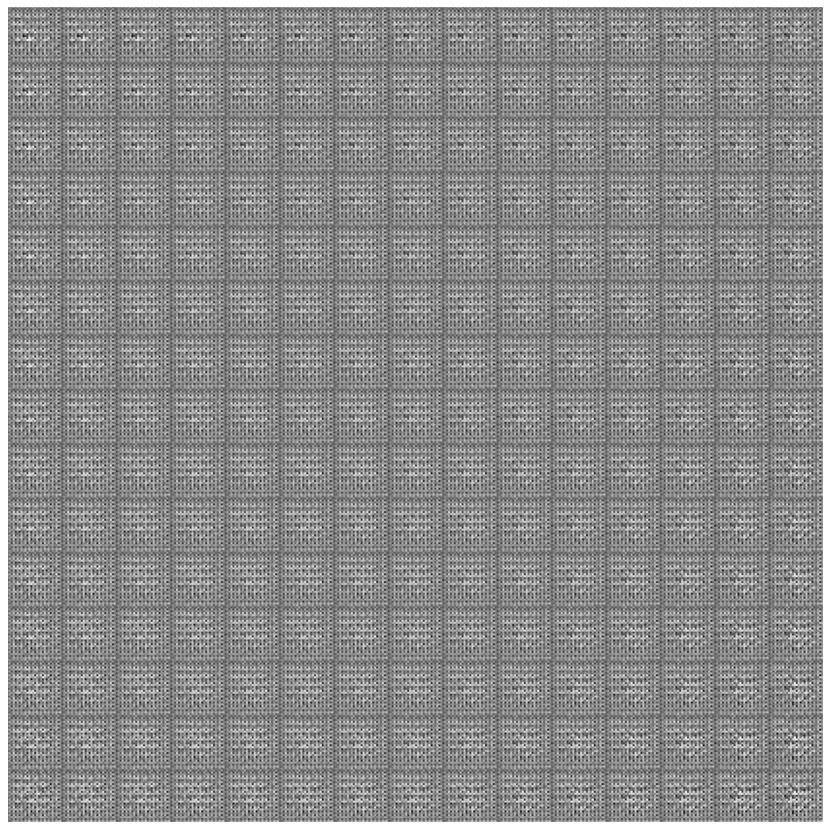

In [20]:
model.eval()
_img = draw_manifold(model, label=8, show=True)

In [21]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [22]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.notebook.trange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.notebook.tqdm(train_loader, leave=False):
            batch_x = batch_x.to(device)
            batch_label = batch_label.to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x, batch_label)

            kl_loss = 0.5 * torch.mean(torch.sum(mu_values.pow(2) + torch.exp(log_sigma_values) - log_sigma_values - 1., dim=-1))
            bce_loss = 28*28*loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss.item()/(len(train_loader.dataset))
            bce_acc += bce_loss.item()/(len(train_loader.dataset))
            kl_acc += kl_loss.item()/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [23]:
epochs, figs, latent_distrs = train(150)

Epoch num: 0
Training loss=0.0010, KL divergence=0.0069, BCE Loss=1.6310


Epoch num: 5
Training loss=0.0004, KL divergence=0.0131, BCE Loss=0.6652


Epoch num: 10
Training loss=0.0004, KL divergence=0.0117, BCE Loss=0.5899


Epoch num: 15
Training loss=0.0004, KL divergence=0.0097, BCE Loss=0.5637


Epoch num: 20
Training loss=0.0004, KL divergence=0.0098, BCE Loss=0.5503


Epoch num: 25
Training loss=0.0004, KL divergence=0.0099, BCE Loss=0.5423


Epoch num: 30
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5373


Epoch num: 35
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5338


Epoch num: 40
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5305


Epoch num: 45
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5284


Epoch num: 50
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5260


Epoch num: 55
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5243


Epoch num: 60
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5234


Epoch num: 65
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5215


Epoch num: 70
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5204


Epoch num: 75
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5192


Epoch num: 80
Training loss=0.0003, KL divergence=0.0099, BCE Loss=0.5185


Epoch num: 85
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5175


Epoch num: 90
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5165


Epoch num: 95
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5157


Epoch num: 100
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5152


Epoch num: 105
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5144


Epoch num: 110
Training loss=0.0003, KL divergence=0.0100, BCE Loss=0.5135


Epoch num: 115
Training loss=0.0003, KL divergence=0.0101, BCE Loss=0.5130


Epoch num: 120
Training loss=0.0003, KL divergence=0.0101, BCE Loss=0.5129


Epoch num: 125
Training loss=0.0003, KL divergence=0.0101, BCE Loss=0.5120


Epoch num: 130
Training loss=0.0003, KL divergence=0.0101, BCE Loss=0.5113


Epoch num: 135
Training loss=0.0003, KL divergence=0.0101, BCE Loss=0.5108


Epoch num: 140
Training loss=0.0003, KL divergence=0.0101, BCE Loss=0.5103


Epoch num: 145
Training loss=0.0003, KL divergence=0.0101, BCE Loss=0.5100


In [24]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

<Figure size 720x720 with 0 Axes>

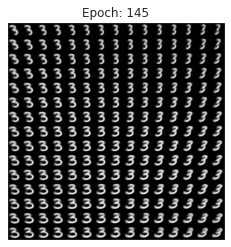

<Figure size 720x720 with 0 Axes>

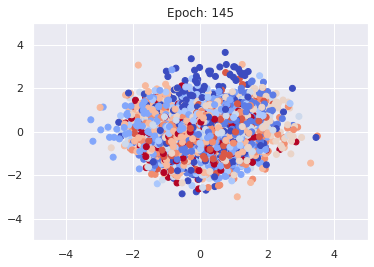

In [25]:
import os
os.makedirs('my_figs', exist_ok=True)


from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    fig = plt.figure()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, writer='ffmpeg', fps=5)

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    fig = plt.figure()
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer='ffmpeg', fps=5)
    
make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.mp4", plt.figure(figsize=(10,10)))
make_2d_scatter_gif([x[0].numpy() for x in latent_distrs], epochs, test_labels, "./my_figs/z_distr2.mp4", plt.figure(figsize=(10,10)))

You can find your brand gifs in `./my_figs/` directory ;)

Let's visualize examples of some class after training.

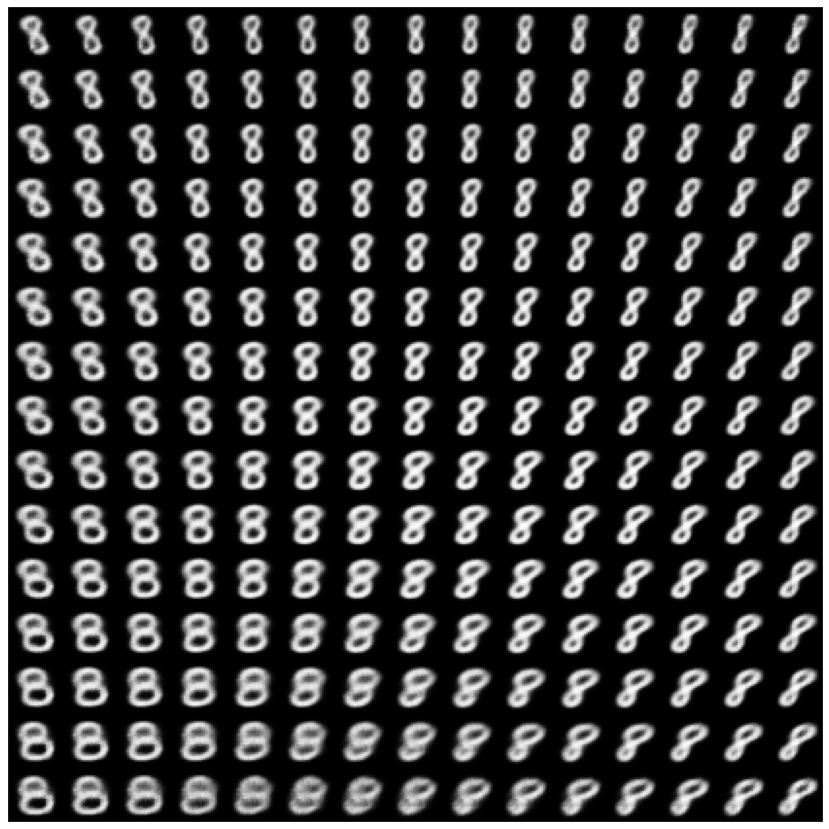

In [26]:
model.eval()
_img = draw_manifold(model, label=8, show=True)

Optionally you can also implement GAN for this task. Good luck!